## Introduction to Supervised Machine Learning
**Instructor:** Lisa-Marie Rolli, Volkamer Lab, Saarland University (lisa-marie.rolli@uni-saarland.de)


**Workshop date:** 13th January 2026

Machine learning (ML) is a research area in computer science, where algorithms are developed to learn from data. Generally, ML can be subdivided into four major realms: (i) supervised learning, (ii) unsupervised learning, (iii) semi-supervised learning, and (iv) reinforcement learning. In this notebook, we focus on supervised ML. In supervised ML, an algorithm learns to predict a specific *response* (e.g., toxicity) for a sample (e.g., compound) based on *features* of the sample (e.g., physicochemical propteries). The learning is based on the assumption that there is a functional relationship between the features and the response, which we can approximate. There exist a plethora of different algorithms, which mainly differ in their assumptions about the true relationship and their learning algorithm, i.e., how they approximate the true function. In this tutorial we will start with linear regression, which assumes a linear relationship between the features and the response.

### Data
As mentioned above, the dataset must consist of *features*, i.e., descriptors of the samples, and a *response*, i.e., a measurement that we want to predict. The goal is to learn a relationship between the features and the response for a given *training set* of samples so that we can later predict for *unseen* samples. In particular, we always separate a hold out *test set*, which is used to evaluate how well our model predicts for samples that it has not seen during training.

The first step in each ML pipeline is understanding the data. Thus, we load a toy dataset with diabetes data and look at the description.

In [37]:
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install rdkit
    !pip install datasail
    !wget https://raw.githubusercontent.com/volkamerlab/Programming4RADAR/refs/heads/first_notebook_draft/Example_Data/solubility_values.tsv
    !wget https://raw.githubusercontent.com/volkamerlab/Programming4RADAR/refs/heads/first_notebook_draft/Example_Data/smiles.tsv

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datasail.sail import datasail
from sklearn.metrics import r2_score, mean_absolute_error
from rdkit import Chem, RDLogger 
from rdkit.Chem import Draw, Descriptors, rdMolDescriptors
from rdkit.Chem import PandasTools
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
RDLogger.DisableLog('rdApp.*')

In [40]:
if not IN_COLAB:
    smiles_df = pd.read_csv('Example_Data/smiles.tsv', sep = '\t', index_col = 0)
else:
    smiles_df = pd.read_csv('smiles.tsv', sep = '\t', index_col = 0)
smiles_df.head()

,SMILES
compound_id,
817354021,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C
884077896,O=C1Nc2cccc3cccc1c23
100491263,Clc1ccc(C=O)cc1
650290313,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...
324766667,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...


Most ML models are not able to directly process text, e.g., SMILES strings. Therefore, we calculate numerical descriptors that are easier for the model to understand. One of the most simple representations are physicochemical properties that we can calculate using RDKit. RDKit is a library that can (among other things) read SMILES and store them as a molecule:

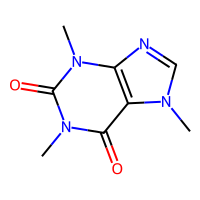

In [41]:
smiles_caffeine = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
caffeine = Chem.MolFromSmiles(smiles_caffeine)
Draw.MolsToImage([caffeine])


After reading the SMILES, we can also caluclate different physiochemical properties of the molcule:

In [42]:
print(f"MolWt: {Descriptors.MolWt(caffeine)}")
print(f"logP: {Descriptors.MolLogP(caffeine)}")
print(f"Num HBA: {rdMolDescriptors.CalcNumHBA(caffeine)}")
print(f"Num HBD: {rdMolDescriptors.CalcNumHBD(caffeine)}")
print(f"Num rotable bonds (RB): {rdMolDescriptors.CalcNumRotatableBonds(caffeine)}")

MolWt: 194.194
logP: -1.0293
Num HBA: 6
Num HBD: 0
Num rotable bonds (RB): 0


Now, we want to calculate some physicochemical properties for all molecules in our ```smiles_df``` data frame.

In [43]:
# ensure that molecules are displayed in dataframe
PandasTools.RenderImagesInAllColumns = True

PandasTools.AddMoleculeColumnToFrame(smiles_df, "SMILES", molCol='molecule')
smiles_df

Failed to patch pandas - unable to change molecule rendering


,SMILES,molecule
compound_id,,
817354021,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,<rdkit.Chem.rdchem.Mol object at 0x00000255E31...
884077896,O=C1Nc2cccc3cccc1c23,<rdkit.Chem.rdchem.Mol object at 0x00000255E31...
100491263,Clc1ccc(C=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x00000255E31...
650290313,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,<rdkit.Chem.rdchem.Mol object at 0x00000255E31...
324766667,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,<rdkit.Chem.rdchem.Mol object at 0x00000255E31...
...,...,...
624359319,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,<rdkit.Chem.rdchem.Mol object at 0x00000255DF1...
215150761,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,<rdkit.Chem.rdchem.Mol object at 0x00000255DF1...
259287587,c1(cc(ccc1C(C)C)C)O,<rdkit.Chem.rdchem.Mol object at 0x00000255DF1...


In [44]:
smiles_df["mol_wt"] = smiles_df["molecule"].apply(Descriptors.MolWt)
# if we have missing values, we remove the molecules
smiles_df.dropna(inplace=True)
smiles_df

,SMILES,molecule,mol_wt
compound_id,,,
817354021,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,<rdkit.Chem.rdchem.Mol object at 0x00000255E31...,392.510
884077896,O=C1Nc2cccc3cccc1c23,<rdkit.Chem.rdchem.Mol object at 0x00000255E31...,169.183
100491263,Clc1ccc(C=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x00000255E31...,140.569
650290313,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,<rdkit.Chem.rdchem.Mol object at 0x00000255E31...,756.226
324766667,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,<rdkit.Chem.rdchem.Mol object at 0x00000255E31...,422.525
...,...,...,...
624359319,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,<rdkit.Chem.rdchem.Mol object at 0x00000255DF1...,264.369
215150761,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,<rdkit.Chem.rdchem.Mol object at 0x00000255DF1...,444.440
259287587,c1(cc(ccc1C(C)C)C)O,<rdkit.Chem.rdchem.Mol object at 0x00000255DF1...,150.221


Now, we load the target, i.e., the continuous values, that we want to predict.

In [45]:
if not IN_COLAB:
    response_df = pd.read_csv('Example_Data/solubility_values.tsv', sep = '\t', index_col = 0)
else:
    response_df = pd.read_csv('solubility_values.tsv', sep = '\t', index_col = 0)
response_df.head()

,LogS
compound_id,
817354021,-3.616127
884077896,-3.254767
100491263,-2.177078
650290313,-3.924409
324766667,-4.662065


As not all molecules are necessarily tested in all assays, we now only take the intersection of molecules with available properties and response.

In [46]:
considered_mols = list(set(smiles_df.index).intersection(set(response_df.index)))
X = smiles_df.loc[considered_mols, ['mol_wt']]
y = response_df.loc[considered_mols]
print(f'We have {len(considered_mols)} molecules in our dataset.')

We have 9982 molecules in our dataset.


Now, we can have a look at the response plotted with respect to the different features (physicochemical properties) that we calculated before:

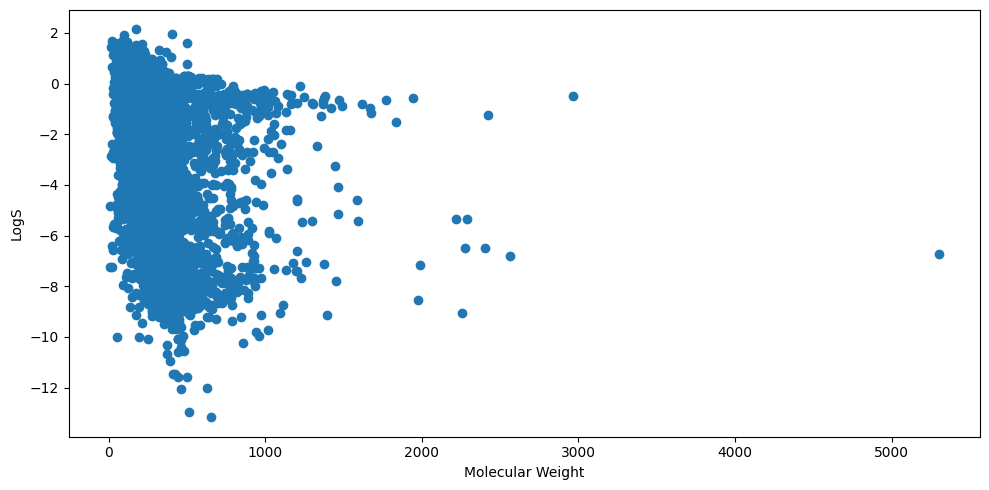

In [47]:
fig, ax = plt.subplots(ncols=len(X.columns), figsize=(10, 5), sharex=False, sharey=True)


ax.scatter(X, y)
ax.set(xlabel='Molecular Weight')
ax.set(ylabel="LogS")
# Optional: add a little padding so points on the edge aren’t cut off


plt.tight_layout()
plt.show()



## Train and Test Set
We can obtain two sets when splitting the data by fingerprint similarity....

In [48]:
e_splits, _, _ = datasail(
    techniques=["C1e"],
    splits=[8, 2],
    names=["train", "test"],
    runs=3,
    solver="SCIP",
    e_type="M",
    e_data=dict(zip(smiles_df.index, smiles_df["SMILES"].values.tolist())),
)
split = e_splits['C1e'][0]

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Jan 07 04:23:51 PM: Your problem has 49 variables, 50 constraints, and 0 parameters.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


(CVXPY) Jan 07 04:23:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 07 04:23:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 07 04:23:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 07 04:23:51 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 07 04:23:51 PM: Compiling problem (target solver=SCIP).
(CVXPY) Jan 07 04:23:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCIP
(CVXPY) Jan 07 04:23:51 PM: Applying reduction Dcp2Cone
(CVXPY) Jan 07 04:23:51 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 07 04:23:51 PM: Applying

In [49]:
train_samples = []
test_samples = []

for sample in split.keys():
    if split[sample] == 'train':
        train_samples.append(sample)
    else:
        test_samples.append(sample)

X_train = X.loc[train_samples, :]
X_test = X.loc[test_samples, :]
y_train = y.loc[train_samples, :]
y_test = y.loc[test_samples, :]

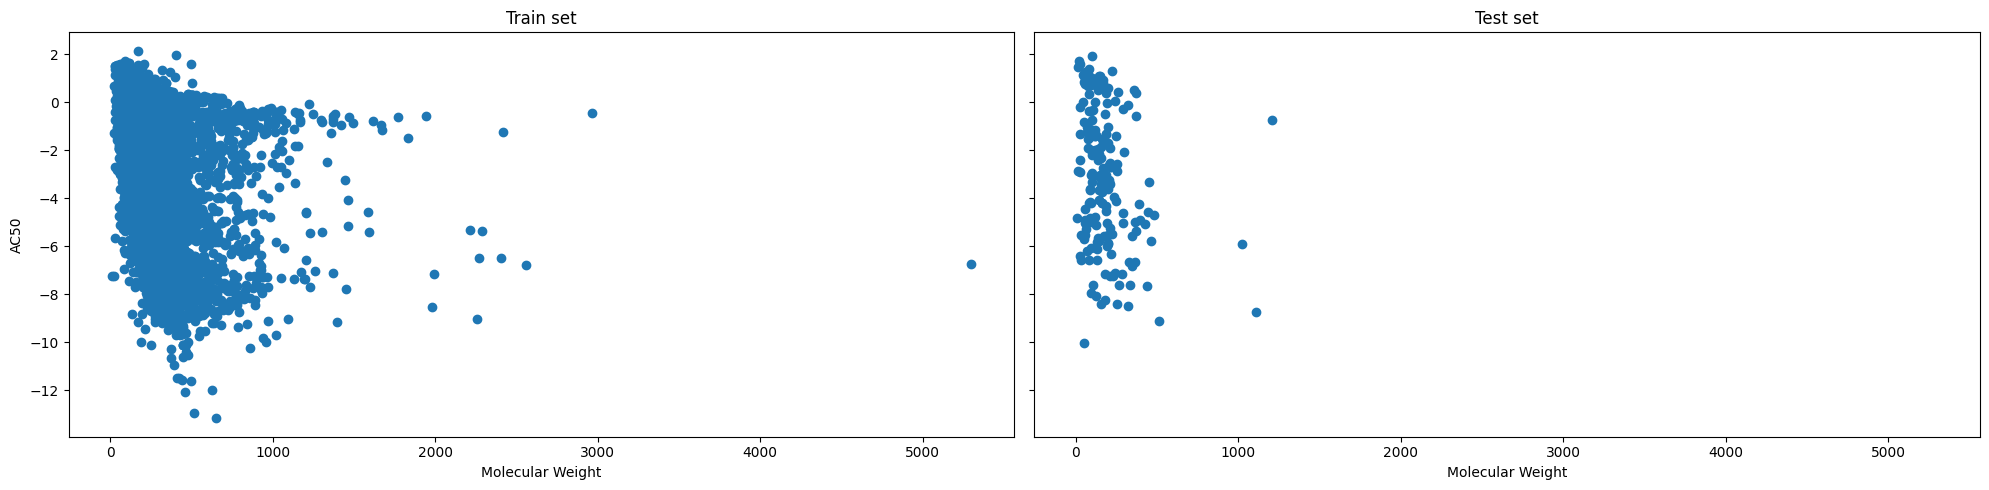

In [50]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5), sharex='row', sharey=True)


ax[0].scatter(X_train, y_train, label = 'Train set')
ax[0].set(xlabel='Molecular Weight', ylabel = 'AC50')
ax[1].scatter(X_test, y_test, label="Test set")
ax[1].set(xlabel='Molecular Weight')
ax[0].set(title = 'Train set')
ax[1].set(title = 'Test set')
plt.tight_layout()
plt.show()

## Model Training
We fit on the training set and predict on the test set. For the fit, we use *least square regression*.

In [51]:
regressor = LinearRegression().fit(X_train, y_train)
y_pred = regressor.predict(X_test)

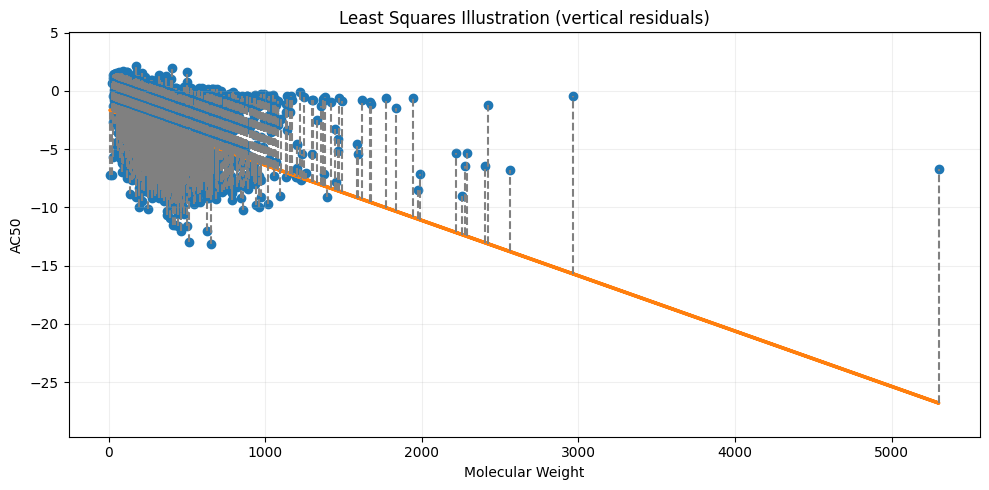

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))

# Scatter points
ax.scatter(X_train, y_train, label="Training points")

train_prediction = regressor.predict(X_train)
# Regression line
ax.plot(X_train, train_prediction, color="tab:orange", lw=2.5)

# Residuals: vertical segments from each point to the line at the same x
for xi, yi, yhi in zip(X_train.values, y_train.values, train_prediction):
    ax.vlines(xi, ymin=min(yi, yhi), ymax=max(yi, yhi),
                color="gray", linestyle="--", lw=1.5)


# Formatting
ax.set_xlabel("Molecular Weight")
ax.set_ylabel("AC50")
title = "Least Squares Illustration (vertical residuals)"

ax.set_title(title)
ax.margins(x=0.05, y=0.1)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()


After fitting the regression line, we can use it to predict for any new data point in our test set:

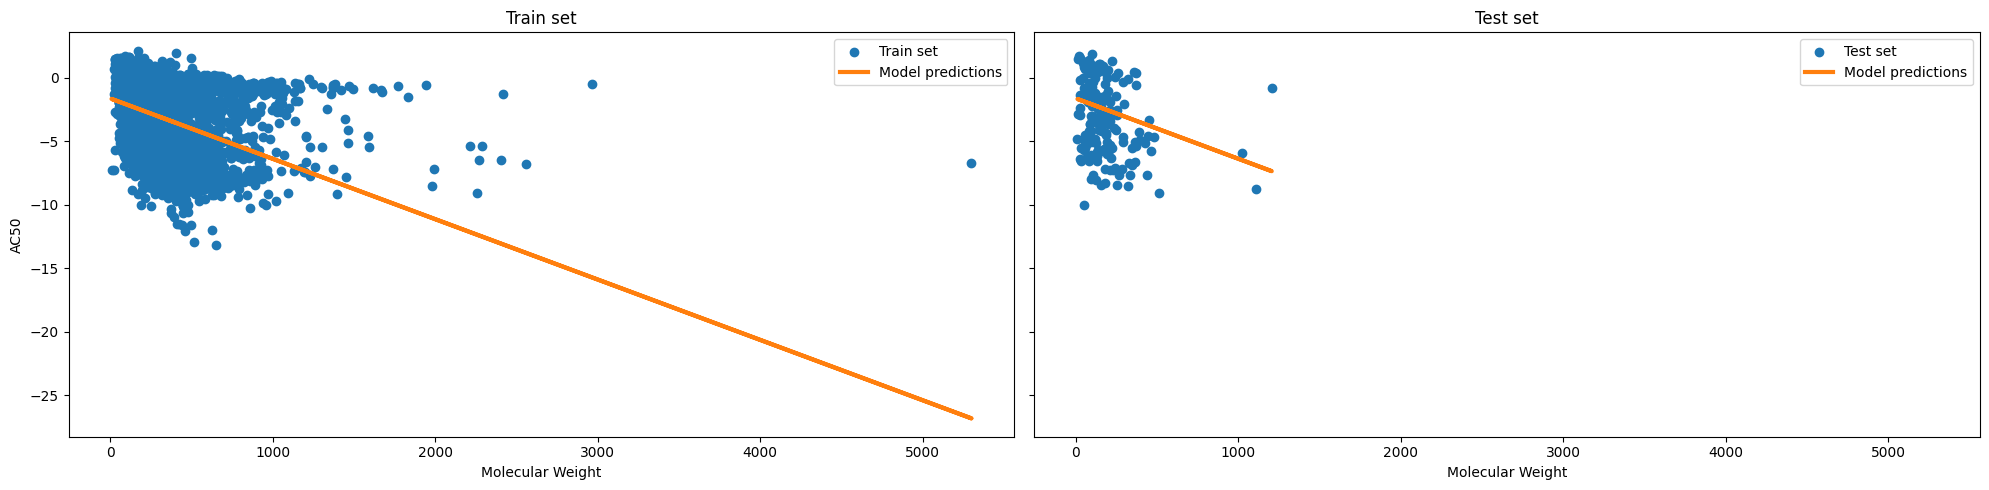

In [53]:
fig, ax = plt.subplots(ncols=2,  figsize=(20,5), sharex='row', sharey=True)


ax[0].scatter(X_train, y_train, label = 'Train set')
ax[0].set(xlabel='Molecular Weight', ylabel = 'AC50')
ax[0].plot(X_train,regressor.predict(X_train),linewidth=3,color="tab:orange", label="Model predictions")
ax[1].scatter(X_test, y_test, label="Test set")
ax[1].set(xlabel='Molecular Weight')
ax[1].plot(X_test, y_pred, linewidth=3, color="tab:orange", label="Model predictions")

ax[0].set(title = 'Train set')
ax[1].set(title = 'Test set')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

From looking at this plot, we can guess that this model does not predict really well. To quantify how good/bad a model *performs*, we use performance metrics such as the mean absolute error (MAE), which tells us how much our prediction $\hat{y}_i$ for a sample $i$ differs from the true value $y_i$ averaged over the number of samples $n$:

$MAE = \frac{1}{n} \cdot \sum_{i = 1}^{n}\vert \hat{y}_i - y_i\vert$

The value is in the same unit as the response (in our case the AC50). Thus, the judgement on whether the observed value is good or bad depends on the dataset. Another metric that is easier to interpret is the *coefficient of determination ($R^2$)*. It is a value in $(-\inf, 1]$, which tells you whether your model was better ($>0$) or worse ($<0$) than simply predicting the mean $\bar{y}$ of the test set.

$R^2 = \frac{\sum_{i = 1}^{n} (\hat{y}_i - y_i)^2}{\sum_{i = 1}^{n} (\bar{y} - y_i)^2}$

In [54]:
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

Mean absolute error: 2.30
Coefficient of determination: 0.05


The metrics reveal what we could already guess from our plot: The model does not perform well. Remember, however, that we only predict the AC50 based on the Molecular Weight. Thus, the next step is to include all 217 physicochemical descriptors to obtain better predictions.

In [55]:
smiles_df['descriptors'] = smiles_df['molecule'].apply(Descriptors.CalcMolDescriptors)

In [63]:
X = smiles_df['descriptors'].apply(pd.Series)
X.dropna(inplace=True)
X = X.astype('float32')
X = X.loc[:, ~X.isin([-np.inf,np.inf ]).any()]

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\dtypes\astype.py:133: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


In [64]:
y = y.loc[X.index, :]

train_samples = list(set(train_samples).intersection(set(X.index)))
test_samples = list(set(test_samples).intersection(set(X.index)))

X_train = X.loc[train_samples, :]
X_test = X.loc[test_samples, :]
y_train = y.loc[train_samples, :]
y_test = y.loc[test_samples, :]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred = linear_model.predict(X_test_scaled)
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

Mean absolute error: 3.78
Coefficient of determination: -43.49


As we can see, the model trained on all descriptors already performed better than the model only trained on Molecular Weight. However, the $R^2$ score is still below 0.

In [65]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)


C:\Users\User\AppData\Local\Temp\ipykernel_1960\793697010.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [66]:
y_pred = rf.predict(X_test)
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

Mean absolute error: 1.01
Coefficient of determination: 0.48
